In [35]:
import folium
import warnings
import geopandas as gpd
import numpy as np
from osgeo import gdal
from osgeo import ogr
import matplotlib.pyplot as plt
from shapely.geometry import Point
warnings.filterwarnings('ignore')

1. CONVERT BFE LINES TO POINT ELEVATIONS
To interpolate area between BFEs it is necessary to convert the original BFE lines to a point dataframe. Since the lines have a constant elevation, two points for each line  will be created with the corresponding BFE line elevation. 

In [36]:
# read in shapefiles and plot
bfe = gpd.read_file('BFEs.shp')
fsp = gpd.read_file('FSP.shp')
m = folium.Map(location=[32.8130102, -96.8010159], zoom_start=16)
bfe_f = folium.GeoJson(data=bfe.to_json())
fsp_f = folium.GeoJson(data=fsp.to_json())
bfe_f.add_to(m)
fsp_f.add_to(m)
m

In [37]:
# Convert LineString geo to Point geo  
bfe.head()

,Name,Elevation,geometry
0,BF1,10,"LINESTRING Z (-96.79929 32.81435 0.00000, -96...."
1,BF2,11,"LINESTRING Z (-96.79979 32.81355 0.00000, -96...."
2,BF3,8,"LINESTRING Z (-96.80041 32.81350 0.00000, -96...."
3,BF4,5,"LINESTRING Z (-96.80109 32.81304 0.00000, -96...."
4,BF5,2,"LINESTRING Z (-96.80113 32.81192 0.00000, -96...."


In [38]:
pts = []
for p in bfe['geometry']:
    x1 = p.xy[0][0]
    y1 = p.xy[1][0]
    x2 = p.xy[0][1]
    y2 = p.xy[1][1]
    pts.append([[x1,y1],[x2,y2]])
    
pts_coords = []
idx = 0
while idx < 2:
    for p in pts:
        pts_coords.append(p[idx])
    idx += 1

print('Numpy Array of x,y coords for each line vertex')
print(pts_coords[:3])

Numpy Array of x,y coords for each line vertex
[[-96.79928865999995, 32.81434883000003], [-96.79979212799998, 32.813547010000036], [-96.80040747699996, 32.81350039300003]]


In [39]:
# create geodataframe with corresponding elevation field via a spatial join 
bf_pts = gpd.GeoDataFrame(geometry=gpd.GeoSeries(map(Point, pts_coords), crs='EPSG:4326'))
bf_pts = gpd.sjoin(bf_pts, bfe, how='left')
bf_pts = bf_pts[['Name', 'Elevation', 'geometry']]
bf_pts

,Name,Elevation,geometry
0,BF1,10,POINT (-96.79929 32.81435)
1,BF2,11,POINT (-96.79979 32.81355)
2,BF3,8,POINT (-96.80041 32.81350)
3,BF4,5,POINT (-96.80109 32.81304)
4,BF5,2,POINT (-96.80113 32.81192)
5,BF1,10,POINT (-96.79837 32.81377)
6,BF2,11,POINT (-96.79878 32.81306)
7,BF3,8,POINT (-96.80003 32.81250)
8,BF4,5,POINT (-96.80053 32.81235)
9,BF5,2,POINT (-96.80044 32.81188)


In [40]:
# add to folium map
bf_pts["x"] = bf_pts.centroid.map(lambda p: p.x)
bf_pts["y"] = bf_pts.centroid.map(lambda p: p.y)
for i in range(0,len(bf_pts)):
    folium.Marker(location=[bf_pts.loc[i, 'y'], bf_pts.loc[i, 'x']],
                  popup=bf_pts.loc[i, ['Name','Elevation']]).add_to(m)
print(bf_pts.groupby('Name')['Elevation'].value_counts())
m

Name  Elevation
BF1   10           2
BF2   11           2
BF3   8            2
BF4   5            2
BF5   2            2
Name: Elevation, dtype: int64


In [7]:
# write out to shapefile before using in Interpolation process
bf_pts.to_file('bf_pts.shp')

2. NEAREST NEIGHBOR INTERPOLATION USING GDAL

The following shows an example of how to use the nearest neighbor interpolation method in Python. A raster is generated using the sample points from 'bf_pts.shp' and the 'Elevation' field for values. The raster is then clipped to the Flood Surface Polygon (i.e. 'FSP.shp').

In [8]:
# nearest neighbor interpolation
nn = gdal.Grid('nn.tif', 'bf_pts.shp', zfield='Elevation', algorithm='nearest')

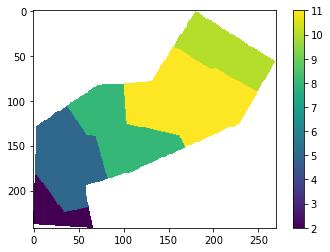

In [9]:
nn_clip = gdal.Warp('nn_clip.tif', nn, cutlineDSName='FSP.shp',
                   cropToCutline=True, dstNodata=np.nan)
array = nn_clip.GetRasterBand(1).ReadAsArray()
plt.imshow(array)
plt.colorbar()

3. INVERSE DISTANCE WEIGHTED INTERPOLATION METHOD (IDW)
The following shows an example of the IDW interpolation method in Python. The power parameter indicates the speed at which the influence of each point reduces as distance increases. Larger values indicate that points loose their influence slower, whereas lower values indicate that points loose their influence faster. A raster is generated using the sample points from 'bf_pts.shp' and the 'Elevation' field for values. The raster is then clipped to the Flood Surface Polygon (i.e. 'FSP.shp').

In [10]:
# IDW Interpolation @ power=4
idw4 = gdal.Grid('idw_4.tif', 'bf_pts.shp', zfield='Elevation', algorithm='invdist:power=4')

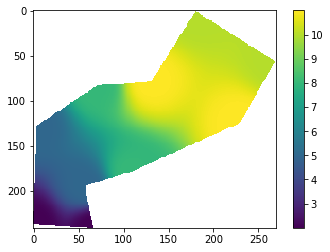

In [11]:
idw_clip4 = gdal.Warp('idw_clip_4.tif', idw4, cutlineDSName='FSP.shp',
                   cropToCutline=True, dstNodata=np.nan)
array = idw_clip4.GetRasterBand(1).ReadAsArray()
plt.imshow(array)
plt.colorbar()

In [12]:
# IDW Interpolation @ power=2
idw2 = gdal.Grid('idw_2.tif', 'bf_pts.shp', zfield='Elevation', algorithm='invdist:power=2')

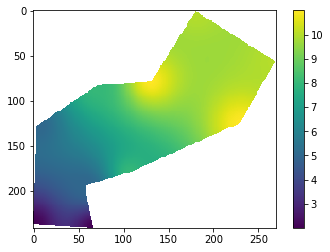

In [13]:
idw_clip2 = gdal.Warp('idw_clip_2.tif', idw2, cutlineDSName='FSP.shp',
                   cropToCutline=True, dstNodata=np.nan)
array = idw_clip2.GetRasterBand(1).ReadAsArray()
plt.imshow(array)
plt.colorbar()

In [14]:
# IDW Interpolation @ power=6
idw6 = gdal.Grid('idw_6.tif', 'bf_pts.shp', zfield='Elevation', algorithm='invdist:power=6')

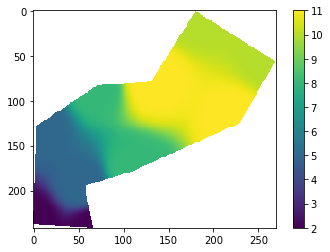

In [15]:
idw_clip6 = gdal.Warp('idw_clip_6.tif', idw6, cutlineDSName='FSP.shp',
                   cropToCutline=True, dstNodata=np.nan)
array = idw_clip6.GetRasterBand(1).ReadAsArray()
plt.imshow(array)
plt.colorbar()